In [1]:
import re
import time

import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

# Step 1: Read CSV and data cleaning

To save typos in the future, we first convert a string that is camelcase into snake_case. Use underscores to avoid spaces in between of compound words.

In [2]:
def camel_to_snake(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def read(file_name):
    if not os.path.isfile(file_name):
        raise ValueError('File Not Found')
        
    ext = file_name.split('.')[-1].lower()
    if 'csv' == ext:
        df = pd.read_csv(file_name)
    elif 'xls' in ext:
        df = pd.read_excel(file_name)
    elif 'json' == ext:
        df = pd.read_json(file_name)
    else:
        raise ValueError('Only support csv, xls and json')

    return df

## Data cleaning and create dummy variables

### Basic description: 
Projects data lists the demographics data of school profiles and associated socio-economic factors, and the project applications data. Outcomes data lists the outcomes(whether it is exciting or not) for each project. To be exciting, a project must meet all of the top five criteria,and meet at least one extra criteria. Donations data comprises donors information and donation details associated with each individual project. Essays data conclude all essay questions funding application materials. Resources data specifies those who requested resources. 

Data choosing criteria: Since the natural language processing is beyond the scope of the project, we will rule 'Essays' dataset out of our analysis.  

### Why we clean our data?

There are many duplicates in donation data as there are many entries for different donors. In short, we clean out the duplicate records via multiple functions, including create dummy variables, count the number of true and false values and produce new variables and sum all the columns up for one single projectid. 

### How do we clean the data and create dummy variables for categorical data?

##### General Principles: 
1. For those categorical data, we create dummy variables for them.
2. Remove essay questions.
3. Keep one row in the donation dataset and resource dataset.

##### Guidebook:
Here are the principles to eliminate duplicate records of donation entries for one project. There are multiple donor records for one project id. In order to remove irrelevant rows, we create dummy variables, or sum up the record entries or count the times for each category for categorical data. In addition, we leave the donation_timestamp which has the latest timestamp in the data.

At the end, we only leave one row of donation record in the donations dataset. The same as resources dataset, where the 'total' are the sums of item price multiply by item_quantity for all donations.


### How do we merge the data?

##### Merging steps: 
Merging is the first step to explore and pre-process data. For this step, I see donation.csv as the master dataset, and merge outcomes, donations and projects datasets on projects dataset. By browsing the head of these dataset, we found the projectid could be used as primary key to merge data as it is the unique identification number that link all these four datasets together. 

##### Merging Principle: 
Because we really care the donation_timestamp. For those projects that don't have donation_timestamps, no matter if they exist in outcomes.csv or projects.csv, we delete them.








In [3]:
PROJECT_PATH ='/home/xinyuan/projects.csv'
OUTCOME_PATH ='/home/xinyuan/outcomes.csv'
DONATION_PATH ='/home/xinyuan/donations.csv'
RESOURCE_PATH ='/home/xinyuan/resources.csv'

In [4]:
def TandF(data, column_name):
    t = data[data[column_name]=='t']
    t = t[['projectid',column_name]].groupby(['projectid']).count()
    t = t.reset_index()
    t = t.rename(columns={column_name:column_name+'_t'})
    
    
    f = data[data[column_name]=='f']
    f = f[['projectid',column_name]].groupby(['projectid']).count()
    f = f.reset_index()
    f = f.rename(columns={column_name:column_name+'_f'})
    
    return t, f

In [5]:
def payment_method(data, val):
    pament_method_range = data[data['payment_method']==val]
    pament_method_range = pament_method_range[['projectid','payment_method']].groupby(['projectid']).count()
    pament_method_range = pament_method_range.reset_index()
    pament_method_range = pament_method_range.rename(columns={'payment_method':'payment_method_'+val})
    return pament_method_range

In [6]:
def dollar_amount(data, val):
    dollor_amount_range = data[data['dollar_amount']==val]
    dollor_amount_range = dollor_amount_range[['projectid','dollar_amount']].groupby(['projectid']).count()
    dollor_amount_range = dollor_amount_range.reset_index()
    dollor_amount_range = dollor_amount_range.rename(columns={'dollar_amount':'dollar_amount_'+val})
    return dollor_amount_range

In [7]:
def process_donation(dpath):
    data = pd.read_csv(dpath, usecols=[1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    
    
    ### process t and f count
    donation_to_project_total= data[['projectid','donation_to_project']].groupby('projectid').sum()
    donation_optional_support = data[['projectid','donation_optional_support']].groupby('projectid').sum()
    donation_total = data[['projectid','donation_total']].groupby('projectid').sum()
    donation_to_project_total = donation_to_project_total.reset_index()
    donation_optional_support = donation_optional_support.reset_index()
    donation_total = donation_total.reset_index()
    donation_to_project_total = donation_to_project_total.rename(columns={'donation_to_project':'donation_to_project_total'})
    donation_optional_support = donation_optional_support.rename(columns={'donation_optional_support':'donation_optional_support_total'})
    donation_total = donation_total.rename(columns={'donation_total':'donation_total_total'})
    
    data = data.merge(donation_to_project_total, how='left', on='projectid')
    data = data.merge(donation_optional_support, how='left', on='projectid')
    data = data.merge(donation_total, how='left', on='projectid')
    
    
    for column in ['is_teacher_acct','donation_included_optional_support',
                   'payment_included_acct_credit','payment_included_campaign_gift_card',
                   'payment_included_web_purchased_gift_card','payment_was_promo_matched',
                   'via_giving_page','for_honoree']:
        t, f = TandF(data, column)
        data = data.merge(t, how='left', on='projectid')
        data[column+'_t'] = data[column+'_t'].fillna(0)
        data = data.merge(f, how='left', on='projectid')
        data[column+'_f'] = data[column+'_f'].fillna(0)
    
    
    #######process dollar amount
    for val in ['under_10','10_to_100','100_and_up']:
        dollar_amount_range = dollar_amount(data, val)
        data = data.merge(dollar_amount_range, how='left', on='projectid')
        data['dollar_amount_'+val] = data['dollar_amount_'+val].fillna(0) 
    
    
    
    ### payment method process
    payment_methods = data['payment_method'].drop_duplicates().tolist()
    for payment_method_type in payment_methods:
        payment_method_range = payment_method(data, payment_method_type)
        data = data.merge(payment_method_range, how='left', on='projectid')
        data['payment_method_'+payment_method_type] = data['payment_method_'+payment_method_type].fillna(0)

    
    data['donation_timestamp'] = pd.to_datetime(data['donation_timestamp'])
    do_time = data[['projectid','donation_timestamp']].groupby('projectid').max()
    #data = data.drop(['donation_timestamp'], axis=1)
    do_time = do_time.reset_index()
    data = do_time.merge(data, how='left', on=['projectid','donation_timestamp'])
    
    data = data.drop_duplicates()
    return data

In [8]:
def process_project(dpath):
    data = pd.read_csv(dpath,usecols=[0,7,12,13,14,15,16,17,18,19,20,22,25,26,27,28,29,30,31,32,33,34])
    
    
    ### dummy varible for 'school_state..etc'
    school_state = pd.get_dummies(data['school_state'], prefix='school_state')
    teacher_prefix = pd.get_dummies(data['teacher_prefix'], prefix='teacher_prefix')
    primary_focus_area = pd.get_dummies(data['primary_focus_area'], prefix='primary_focus_area')
    poverty_level =  pd.get_dummies(data['poverty_level'], prefix='poverty_level')
    resource_type = pd.get_dummies(data['resource_type'], prefix='resource_type')
    grade_level = pd.get_dummies(data['grade_level'], prefix='grade_level')
    #print(school_state)
    data = pd.concat([data, school_state, teacher_prefix, 
                      primary_focus_area, poverty_level,
                      resource_type, grade_level],axis=1)
    
    data = data.drop_duplicates()
    
    return data

In [9]:
def  dummy_project_resource_type(data, val):
    dprt_range = data[data['project_resource_type']==val]
    dprt_range = dprt_range[['projectid','project_resource_type']].groupby(['projectid']).count()
    dprt_range = dprt_range.reset_index()
    dprt_range = dprt_range.rename(columns={'project_resource_type':'project_resource_type_'+val})
    return dprt_range

In [10]:
def process_resource(dpath):
    data = pd.read_csv(dpath, usecols=[1,4,7,8])
    
    project_resource_types = data['project_resource_type'].drop_duplicates().tolist()
    for val in project_resource_types:
        val = str(val)
        dprt_range = dummy_project_resource_type(data, val)
        data = data.merge(dprt_range, how='left', on='projectid')
        data['project_resource_type_'+val] = data['project_resource_type_'+val].fillna(0)
    
    data['total'] = data['item_unit_price']*data['item_quantity']
    total = data[['projectid','total']].groupby('projectid').sum()
    total = total.reset_index()
    data = data.drop(['total'],axis=1)
    data = data.merge(total, how='left', on='projectid')
    data = data[['projectid','total']]
    
    data = data.drop_duplicates()
    #print(data)
    return data

In [11]:
def process_outcome(dpath):
    #data = pd.read_csv(dpath)
    #print(data.columns)
    return None

In [12]:
prod = process_donation(DONATION_PATH)
prop = process_project(PROJECT_PATH)
pror = process_resource(RESOURCE_PATH)

data = prod.merge(prop, how='left', on='projectid')
data = data.merge(pror, how='left', on='projectid')

In [13]:
outcome = pd.read_csv(OUTCOME_PATH)
data = data.merge(outcome, how='left',on='projectid')

In [14]:
data

projectid      donation_timestamp  donor_zip  \
0       00001ccc0e81598c4bd86bacb94d7acb 2013-05-23 12:19:59.516    10014.0   
1       00002bff514104264a6b798356fdd893 2011-01-21 14:54:39.561    94102.0   
2       00002d691c05c51a5fdfbb2baef0ba25 2011-04-28 21:00:06.714        NaN   
3       0000b38bbc7252972f7984848cf58098 2013-12-23 11:22:42.795    94102.0   
4       0000ee613c92ddc5298bf63142996a5c 2013-12-31 15:40:53.928    22310.0   
5       0000fa3aa8f6649abab23615b546016d 2012-04-25 11:29:12.334        NaN   
6       0000fb6aea57099cc5b051acb7f52a9e 2012-11-21 02:21:05.578        NaN   
7       0001120447a33dd9ffeefa107ed04c43 2008-02-01 13:59:51.831    10003.0   
8       0001146d343ea9452089d0e302496c06 2011-12-15 15:26:17.451    29732.0   
9       0001151477ea5349a0aa64ed1d83f0bc 2009-10-16 13:55:43.216    60640.0   
10      000134f07d4b30140d63262c871748ff 2012-03-01 21:04:15.424        NaN   
11      0001465527a44c2db6258ecef4ff73ab 2012-07-15 18:30:02.132    60102.0   
12      00014917b8c23b8170b2c78df4f094c4 2013-04-23 19:14:48.153        NaN   
13      00014ba2b351fc0573b94828aa742bec 2008-09-26 18:04:20.865    27601.0   
14      000172f669937044911a57d06eafd360 2009-12-31 20:21:56.383    32726.0   
15      00017d99c933cb7888c63abbd807f406 2013-11-05 19:12:12.281    10017.0   
16      0001820eac84ab9cb11659bd1daf2a7d 2010-02-05 17:27:55.313    70131.0   
17      0001cd238ed6959ff8650888aaf18dce 2011-01-03 23:53:41.516     6905.0   
18      0001f2d0b3827bba67cdbeaa248b832d 2012-10-14 01:05:51.889        NaN   
19      0002226cc1bacb72071c0c9578493fd6 2010-07-25 17:58:33.833    10001.0   
20      0002386291b6c2c659a34664fbaca804 2014-04-05 11:06:52.979        NaN   
21      00023c177bd5f268d0c7c23894dec129 2013-10-29 23:02:15.990    48331.0   
22      00029b5d84a5754432d783d2cda868e4 2003-10-26 14:12:17.000        NaN   
23      00029fe2570371d867a69cfdde05daed 2009-03-05 21:23:26.265    90895.0   
24      0002cc8698b7cfe4efa092eb022c43bf 2010-12-28 16:48:59.394    10001.0   
25      0002f8f3999db6d17e5a417e5e641b7f 2011-12-23 01:27:55.259    94102.0   
26      00030653a33d0657cf9ffb494a059a7e 2011-03-15 14:34:15.993    48183.0   
27      000308a4c89c470812b393ce91cbcb0d 2013-08-28 10:18:28.606    94925.0   
28      00031003596c97b3f0b9f7821cbd1d9f 2013-08-01 15:33:17.787        NaN   
29      00035524f23e84b060b3f7077f62b523 2009-12-16 14:30:27.478        NaN   
...                                  ...                     ...        ...   
525329  fffb88aa251449f1ba0b31d5552426b0 2012-03-02 16:18:22.928    98052.0   
525330  fffb9b153b3486b2b8c701af5661ffd8 2012-02-03 13:01:52.143    37804.0   
525331  fffbc23d5c2ece64168af350ab9f6cad 2013-10-28 15:51:43.206    92870.0   
525332  fffbfa03410617e6d606dbb288a71872 2008-01-24 18:33:23.678    70131.0   
525333  fffc128714a3035d7af7637c4ab30615 2013-12-15 04:51:51.360    92101.0   
525334  fffc3632fd681fde1113eae31ca027d4 2013-03-17 21:09:25.226        NaN   
525335  fffc602212a37bd35f49c51d2cd6a514 2011-09-20 19:14:44.986    94102.0   
525336  fffca85fb3541898739575698075a92c 2011-05-11 21:43:14.526        NaN   
525337  fffcab52aff6aec5843afafe919d4a06 2013-04-15 15:58:23.457        NaN   
525338  fffccbe76c1fc9e660b5189d5f83a2e7 2011-05-10 08:39:57.621        NaN   
525339  fffccdc88058ff2ac3ea35881021ef59 2011-09-07 16:03:54.283    75093.0   
525340  fffcfa4388e8ac482c44734bffa891c8 2012-08-02 12:07:05.418        NaN   
525341  fffd7e92ef92f4f29f5ad86e82081c66 2010-07-29 09:01:24.843    32825.0   
525342  fffda9a35e156656df0a2e2c7091e9cf 2013-10-21 23:13:05.856        NaN   
525343  fffdf9d286e715165b60674ac9d05c6c 2013-10-17 13:23:39.700    48763.0   
525344  fffdfafaf7cc8fdd9b6567051b394da7 2013-10-10 23:05:28.672        NaN   
525345  fffe0476e16862c4892e97926489986c 2013-02-26 21:18:08.611    33596.0   
525346  fffe0bb8af3b9cd93046b49653cc923a 2012-09-06 21:09:09.529     8759.0   
525347  fffe426c60834b0ba2eb05f759d854da 2008-04-08 16:53:47.341    10017.0   
52

In [15]:
df = data
df.count()

projectid                                         525359
donation_timestamp                                525359
donor_zip                                         328169
is_teacher_acct                                   525359
donation_to_project                               525359
donation_optional_support                         525359
donation_total                                    525359
dollar_amount                                     525359
donation_included_optional_support                525359
payment_method                                    525359
payment_included_acct_credit                      525359
payment_included_campaign_gift_card               525359
payment_included_web_purchased_gift_card          525359
payment_was_promo_matched                         525359
via_giving_page                                   525359
for_honoree                                       525359
donation_to_project_total                         525359
donation_optional_support_total

# Step 2：Explore Data

## 2.1 Basic info

## 2.2 Data discriptions

In this section, we want know the distributions of these variables, and correlations between these variables, as well as the changes and trends over time.

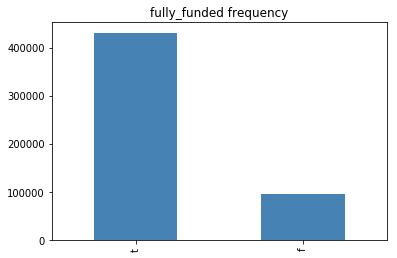

In [16]:
df['fully_funded'].value_counts().plot.bar(title = "fully_funded frequency", color = "steelblue")

In [20]:
ratio = df["fully_funded"].value_counts(normalize = True)
ratio

t    0.819697
f    0.180303
Name: fully_funded, dtype: float64

In [17]:
sum_cols = ['fully_funded']
df_by_day = df[sum_cols + ['date_posted']]
df_by_day = df_by_day.replace('t', 1).replace('f', 0)
df_by_day = df_by_day.set_index('date_posted')
df_by_day.index = pd.to_datetime(df_by_day.index)
df_by_day['year'] = df_by_day.index.year
df_by_year_sum = df_by_day.groupby('year').sum()
df_by_year_mean = df_by_day.groupby('year').mean()

<Figure size 432x288 with 0 Axes>

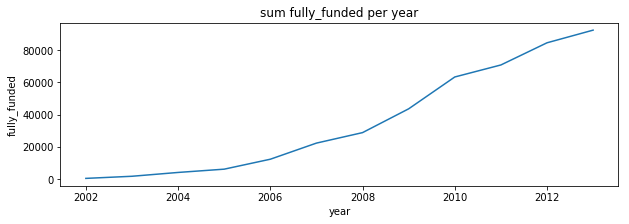

fully_funded
year              
2002           457
2003          1770
2004          4140
2005          6173
2006         12340

In [18]:
def plot_hist(df, name='mean'):
    for col in df.columns:
        plt.clf()
        plt.figure(figsize=(10, 3))
        plt.plot(df.index, df[col],'')  
        plt.xlabel('year')
        plt.ylabel(col)
        plt.title('{} {} per year'.format(name, col))
        plt.show()

plot_hist(df_by_year_sum, 'sum')
df_by_year_sum.head()

<Figure size 432x288 with 0 Axes>

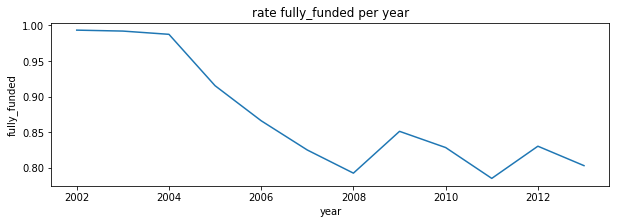

fully_funded
year              
2002      0.993478
2003      0.992152
2004      0.987595
2005      0.915468
2006      0.866269

In [19]:
plot_hist(df_by_year_mean, 'rate')
df_by_year_mean.head()